In [1]:
from Quantum_Games import player, entanglement_layer, game_circuit
from qiskit.circuit.library import RYGate
import pandas as pd

from qiskit import QuantumCircuit
import numpy as np

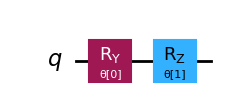

In [2]:
from qiskit.circuit.library import efficient_su2

strategy = efficient_su2(1, reps=0)
strategy.draw('mpl')

In [3]:
params = [(np.random.uniform(0, 4 * np.pi), np.random.uniform(0, 4 * np.pi)) for _ in range(10)]
strategies = [efficient_su2(1, reps=0).assign_parameters(parameters=param) for param in params]
probabilities = [1/len(strategies) for _ in range(len(strategies))]

alice = player(name='alice',
                strategies=strategies,
                probabilities=probabilities)

In [4]:
params = [(np.random.uniform(0, 4 * np.pi), np.random.uniform(0, 4 * np.pi)) for _ in range(10)]
strategies = [efficient_su2(1, reps=0).assign_parameters(parameters=param) for param in params]
probabilities = [1/len(strategies) for _ in range(len(strategies))]

bob = player(name='bob',
                strategies=strategies,
                probabilities=probabilities)

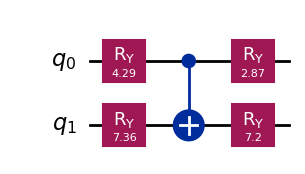

In [14]:
from qiskit.circuit.library import real_amplitudes

referee = real_amplitudes(2, reps=1, name='referee')
referee.assign_parameters(4*np.pi*np.random.rand(referee.num_parameters), inplace=True)
referee.draw('mpl')

In [18]:
circuit = game_circuit(players=[alice, bob],
                       referee_ansatz=referee,
                       insert_barriers=True)

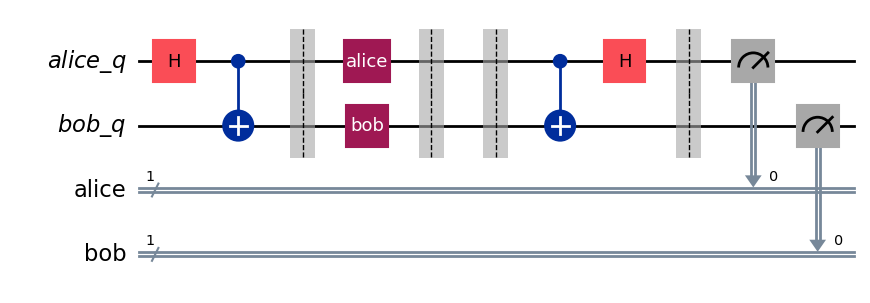

In [7]:
circuit.draw('mpl')

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler

def get_aer_result(circuits, num_shots=1000):
    if not isinstance(circuits, list):
        circuits = [circuits]
    backend = AerSimulator()
    sampler = Sampler(mode=backend)
    transpiled = transpile(circuits, backend=backend)
    result = sampler.run(transpiled, shots = num_shots).result()[0].data
    dict_results = {player : [] for player in result.keys()}
    for player in result.keys():
        dict_results[player]=result[player].array.flatten().tolist()

    return dict_results

result = get_aer_result(circuit)

In [11]:
df = pd.DataFrame(result)
print(df)

     alice  bob
0        0    1
1        0    1
2        0    1
3        1    1
4        0    1
..     ...  ...
995      0    1
996      0    1
997      0    1
998      0    1
999      0    1

[1000 rows x 2 columns]


In [12]:
def calculate_payout(results):
    outcomes = {'(0, 0)' : (3,3), '(0, 1)' : (0,5),
                '(1, 0)' : (5,0),'(1, 1)' : (1,1)}
    player_results = {player : [] for player in result.keys()}
    player_1 = 'alice'
    player_2 = 'bob'

    for p1, p2  in zip(results[player_1], results[player_2]):
        p1_outcome, p2_outcome = outcomes[str((p1,p2))]
        player_results[player_1].append(p1_outcome)
        player_results[player_2].append(p2_outcome)

    return player_results

In [13]:
player_results = calculate_payout(result)

print('Alice average result: ', np.mean(player_results['alice']))
print('Bob average result: ', np.mean(player_results['bob']))

Alice average result:  0.222
Bob average result:  4.142
